In [157]:
import matplotlib.pyplot as plt
import numpy as np

import collections
import math
import random

numpy.seterr('raise');
EPSILON = 1e-7

In [191]:
def prob_normal_distribution(a, b):
    return 1 / math.sqrt(2 * math.pi * b) * math.exp(-0.5 * a**2 / b)

def prob_triangular_distribution(a, b):
    return max(0, 1 / math.sqrt(6) * b - abs(a) / 6 / b)

# Taken from Kalman Filter book
def normalize_angle(x):
    x = x % (2 * math.pi)
    if x > math.pi:
        x -= 2 * math.pi
        
    return x

# TODO: Test this function
def motion_model_velocity(x_t, u_t, x_, dt, prob, a_1, a_2, a_3, a_4, a_5, a_6):
    '''
    We evaluate the required input to bring x_ to x_t.
    Then, we evaluate the error between the given input the the calculated input.
    Assuming independence of the three movement errors, we compute the probability that we get these errors.
    '''
    x, y, theta = x_t
    x_, y_, theta_ = x_
    v, w = u_t
    mu = 0.5 * ((x - x_) * math.cos(theta) + (y - y_) * math.sin(theta) + EPSILON) / ((y - y_) * math.cos(theta) - (x - x_) * math.sin(theta) + EPSILON)
    x_star = (x + x_) / 2 + mu * (y - y_)
    y_star = (y + y_) / 2 + mu * (x - x_)
    r_star = math.sqrt((x - x_star)**2 + (y - y_star)**2)
    delta_theta = math.atan2(y_ - y_star, x_ - x_star) - math.atan2(y - y_star, x - x_star)
    v_ = delta_theta / dt * r_star
    w_ = delta_theta / dt
    gamma = normalize_angle((theta_ - theta) / dt - w_)
    
    return prob(v - v_, a_1 * v**2 + a_2 * w**2) * prob(w - w_, a_3 * v**2 + a_4 * w**2) * prob(gamma, a_5 * v**2 + a_6 * w**2)

def sample_normal_distribution(b):
    return random.gauss(0, b)

def sample_triangular_distribution(b):
    return math.sqrt(6) / 2 * (random.uniform(-b, b) + random.uniform(-b, b))

def sample_motion_model_velocity(u_t, x_, dt, sample, a_1, a_2, a_3, a_4, a_5, a_6):
    '''
    We evaluate one possible final state given an input.
    Calling this function many times will result in different outputs.
    This can be used in conjunction with particle filters.
    '''
    x, y, theta = x_
    v, w = u_t
    v_ = v + sample(a_1 * v**2 + a_2 * w**2)
    w_ = w + sample(a_3 * v**2 + a_4 * w**2)
    gamma = sample(a_5 * v**2 + a_6 * w**2)
    x_ = x - v_ / w_ * math.sin(theta) + v_ / w_ * math.sin(theta + w_ * dt)
    y_ = y + v_ / w_ * math.cos(theta) - v_ / w_ * math.cos(theta + w_ * dt)
    theta_ = normalize_angle(theta + w_ * dt + gamma * dt)
    
    return np.array([x_, y_, theta_])

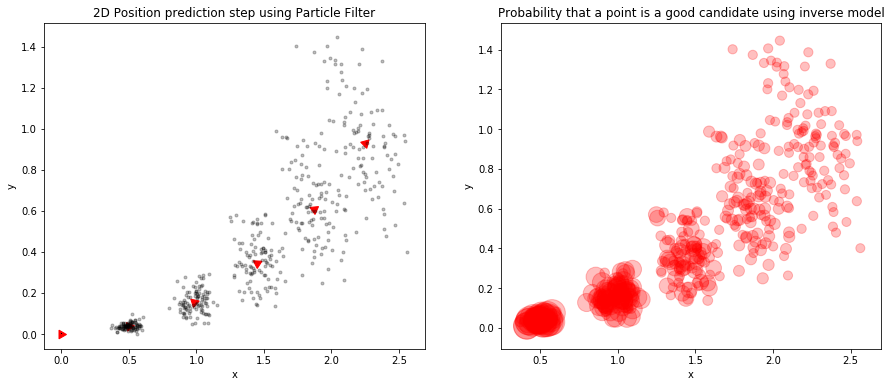

In [216]:
def sample_motion_model_velocity_n(u_t, positions, dt, sample, a_1, a_2, a_3, a_4, a_5, a_6):
    x_s = []
    y_s = []
    theta_s = []
    for position in zip(*positions):
        x, y, theta = sample_motion_model_velocity(u_t, position, dt, sample, a_1, a_2, a_3, a_4, a_5, a_6)
        x_s.append(x)
        y_s.append(y)
        theta_s.append(theta)
        
    return x_s, y_s, theta_s

def motion_model_velocity_n(positions, u_t, prev_positions, dt, prob, a_1, a_2, a_3, a_4, a_5, a_6):
    p_s = np.zeros(len(positions))
    for i in range(len(positions)):
        position = positions[0][i], positions[1][i], positions[2][i]
        prev_position = prev_positions[0][i], prev_positions[1][i], prev_positions[2][i]
        p_s[i] = motion_model_velocity(position, u_t, prev_position, dt, prob, a_1, a_2, a_3, a_4, a_5, a_6)
        
    return p_s

def simulate_predict_step():
    DT = 0.5
    N_POINTS = 100
    N_EPOCH = 5

    u = np.array([1, math.pi / 10])
    sample = sample_normal_distribution
    prob = prob_normal_distribution
    a_1, a_2, a_3, a_4, a_5, a_6 = 0.1, 0.1, 0.1, 0.1, 0.1, 0.1

    x_s = np.zeros(N_POINTS)
    y_s = np.zeros(N_POINTS)
    theta_s = np.zeros(N_POINTS)
    
    prev_x_s = None
    prev_y_s = None
    prev_theta_s = None

    perfect_model = np.zeros(3)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
    axes[0].plot(x_s, y_s, 'k,', alpha=1)
    for _ in range(N_EPOCH):
        prev_x_s, prev_y_s, prev_theta_s = x_s, y_s, theta_s
        x_s, y_s, theta_s = sample_motion_model_velocity_n(u, (x_s, y_s, theta_s), DT, sample, a_1, a_2, a_3, a_4, a_5, a_6)
        perfect_model = sample_motion_model_velocity(u, perfect_model, DT, sample, 0, 0, 0, 0, 0, 0)
        p_s = motion_model_velocity_n((x_s, y_s, theta_s), u, (prev_x_s, prev_y_s, prev_theta_s), DT, prob, a_1, a_2, a_3, a_4, a_5, a_6)
        
        axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
        axes[0].plot(x_s, y_s, 'k.', alpha=0.25)
        
        axes[1].scatter(x_s, y_s, s=((p_s + 1) * 3)**4, c='r', alpha=0.25)

    axes[0].set_title('2D Position prediction step using Particle Filter')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y');
    
    axes[1].set_title('Probability that a point is a good candidate using inverse model')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    
simulate_predict_step()